# BLG556E - Digital Solution for Smart Cities

Halit Uyanık - 504202506<br>
Kadir Şinas Kaynak - 504191525


In [157]:
import os
import sys
import urllib.request
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt
from utilities.PreProcessingUtil import preprocessing

In [158]:
#read pollutant values
# A N by T feature matrix, which describes the (f_1, .., f_T) speed records over T timesteps for the N sensors.
dfPollutant = pd.read_excel(
     "datasets/pollutants/mecidiyekoy.xlsx",
     engine='openpyxl',
     parse_dates=True,
     thousands='.'
)



In [159]:
#remove index column
dfPollutant = dfPollutant.iloc[: , 1:] 

#dataset info
time_len, num_pol = dfPollutant.shape
print("No. of pollution:", num_pol-1, "\nNo of timesteps:", time_len)

No. of pollution: 6 
No of timesteps: 71495


In [160]:
dfPollutant = dfPollutant.iloc[-20001:,:]

In [163]:
dfPollutant=preprocessing(dfPollutant)

/Users/deneme/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


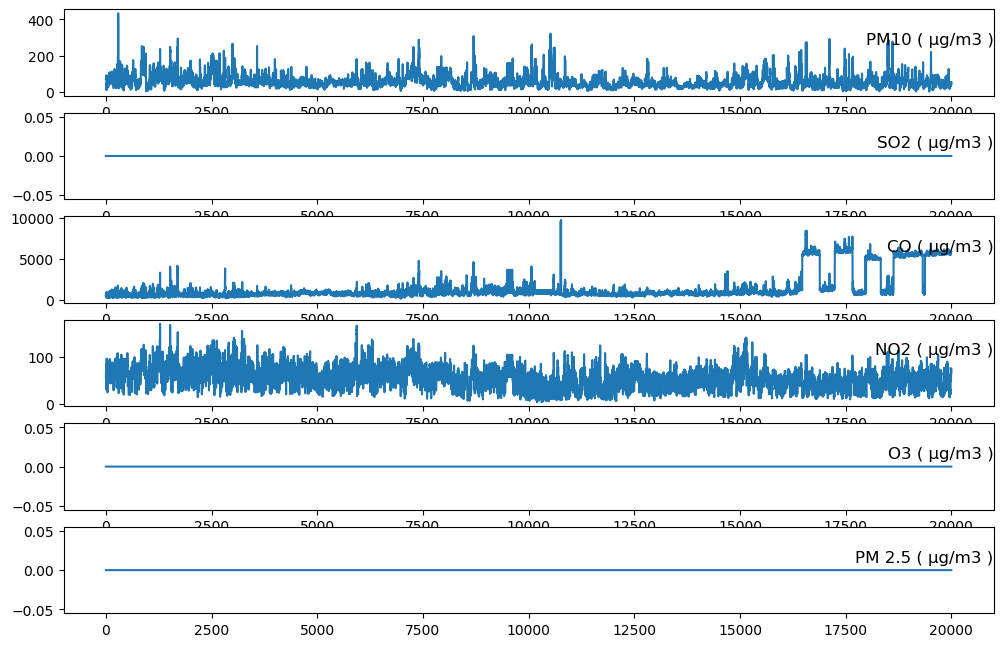

In [164]:
values = dfPollutant.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6]
i = 1
# plot each column
plt.figure(figsize=(12, 8), dpi=100)
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dfPollutant.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [165]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [166]:
# load dataset
values = dfPollutant.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.163116        0.0   0.039814   0.327608   0.152109        0.0   
2   0.162930        0.0   0.046558   0.347298   0.165868        0.0   
3   0.170287        0.0   0.037936   0.408582   0.204004        0.0   
4   0.173257        0.0   0.037124   0.401999   0.209160        0.0   
5   0.184048        0.0   0.045836   0.451972   0.246460        0.0   

   var7(t-1)   var1(t)  
1        0.0  0.162930  
2        0.0  0.170287  
3        0.0  0.173257  
4        0.0  0.184048  
5        0.0  0.183213  


In [167]:
train_rate = 0.8
# split into train and test sets
values = reframed.values
n_train_hours = reframed.shape[0] * train_rate
int(n_train_hours)

16000

In [168]:
train_rate = 0.8
# split into train and test sets
values = reframed.values
n_train_hours = int(reframed.shape[0] * train_rate)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(16000, 1, 7) (16000,) (4000, 1, 7) (4000,)


In [169]:
lstm_layer_sizes = 50
lstm_activations = "tanh"
loss='mae'
optimizer='adam'
n_epochs=50
batch_size=72
shuffle=False
verbose=2
# design network
model = Sequential()
model.add(LSTM(lstm_layer_sizes, activation=lstm_activations, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss=loss, optimizer=optimizer)
# fit network
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=verbose, shuffle=shuffle)


Epoch 1/50
223/223 - 1s - loss: 0.0401 - val_loss: 0.0401
Epoch 2/50
223/223 - 0s - loss: 0.0263 - val_loss: 0.0456
Epoch 3/50
223/223 - 0s - loss: 0.0205 - val_loss: 0.0395
Epoch 4/50
223/223 - 0s - loss: 0.0196 - val_loss: 0.0336
Epoch 5/50
223/223 - 0s - loss: 0.0190 - val_loss: 0.0306
Epoch 6/50
223/223 - 0s - loss: 0.0188 - val_loss: 0.0274
Epoch 7/50
223/223 - 0s - loss: 0.0185 - val_loss: 0.0251
Epoch 8/50
223/223 - 0s - loss: 0.0184 - val_loss: 0.0259
Epoch 9/50
223/223 - 0s - loss: 0.0184 - val_loss: 0.0250
Epoch 10/50
223/223 - 0s - loss: 0.0183 - val_loss: 0.0258
Epoch 11/50
223/223 - 0s - loss: 0.0181 - val_loss: 0.0249
Epoch 12/50
223/223 - 0s - loss: 0.0182 - val_loss: 0.0253
Epoch 13/50
223/223 - 0s - loss: 0.0182 - val_loss: 0.0262
Epoch 14/50
223/223 - 0s - loss: 0.0182 - val_loss: 0.0263
Epoch 15/50
223/223 - 0s - loss: 0.0180 - val_loss: 0.0286
Epoch 16/50
223/223 - 0s - loss: 0.0180 - val_loss: 0.0258
Epoch 17/50
223/223 - 0s - loss: 0.0180 - val_loss: 0.0284
Epoch 

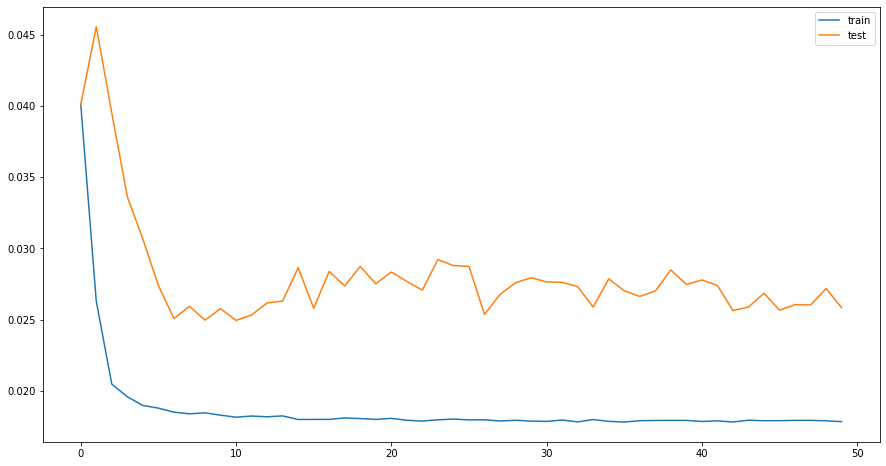

In [170]:
# plot history
fig = plt.figure(figsize=(15, 8))
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [171]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [172]:
print(inv_y[:10])
print(inv_yhat[:10])

[25.31     31.730001 32.23     32.67     35.55     52.24     43.83
 34.34     33.17     37.11    ]
[20.253565 26.526125 33.40024  34.642353 34.503906 37.184612 51.064175
 43.9267   36.197918 35.954407]


In [173]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
mse = mean_squared_error(inv_y, inv_yhat) #y_true, y_pred
rmse = sqrt(mean_squared_error(inv_y, inv_yhat)) #y_true, y_pred
mase = sqrt(mean_absolute_error(inv_y, inv_yhat)) #y_true, y_pred

print('------------------------------------------\n')
print('MSE:',mse)
print('RMSE:',rmse)
print('MASE:',mase)
print('------------------------------------------')

------------------------------------------

MSE: 231.73933
RMSE: 15.222987029701015
MASE: 3.336124173732668
------------------------------------------


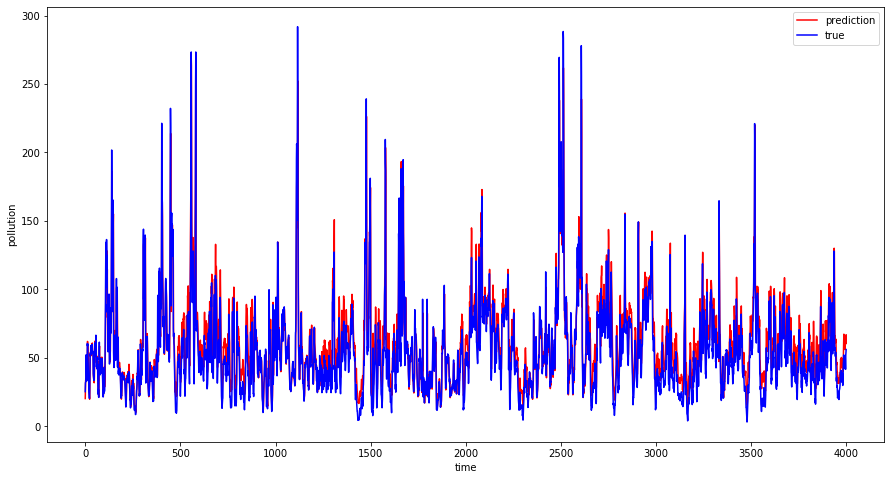

In [174]:
##all test result visualization
fig1 = plt.figure(figsize=(15, 8))
#    ax1 = fig1.add_subplot(1,1,1)
a_pred = inv_yhat[:]
a_true = inv_y[:]
plt.plot(a_pred, "r-", label="prediction")
plt.plot(a_true, "b-", label="true")
plt.xlabel("time")
plt.ylabel("pollution")
plt.legend(loc="best", fontsize=10)
plt.show()

In [175]:
# Output all results to a sub-directory
import datetime
import pathlib
import os
path = pathlib.Path().absolute()
time = datetime.datetime.now().strftime("%m-%d-%Y %H-%M-%S")
result_dir = os.path.join (path, "experiments", time)
os.mkdir (result_dir)

# Create the result txt file
f = open(result_dir + "/" + "summary.txt", "w")

# Write experiment parameters
f.write ("---------Experiment Parameters--------")
f.write ("\nTrain-Test split rate: " + str(train_rate))
f.write ("\nNumber of epochs: " + str(n_epochs))
f.write ("\nBatch size: " + str(batch_size))
f.write ("\nShuffle during training: " + str(shuffle))
f.write ("\nVerbose: " + str(verbose))
f.write ("\n---------------------------")

# Write dataset details
f.write ("\n---------Dataset Details--------")
time_len, pollution_len = dfPollutant.shape
f.write ("\nNo of pollution:" + str(pollution_len-1) + "\nNo of timesteps:" + str(time_len-1))
f.write ("\nTrain data: " + str(train.shape))
f.write ("\nTest data: " + str(test.shape))

f.write ("\nTrain data X: " + str(train_X.shape))
f.write ("\nTrain data Y: " + str(train_y.shape))
f.write ("\nTest data X: " + str(test_X.shape))
f.write ("\nTest data Y: " + str(test_y.shape))
f.write ("\n---------------------------")

# Write model details
f.write ("\n---------Model Details--------")
f.write ("\nLSTM layer sizes: " + str(lstm_layer_sizes))
f.write ("\nLSTM activation functions: " + str(lstm_activations))
f.write ("\nOptimizer: " + optimizer)
f.write ("\nLoss function: " + loss)
f.write ("\n---------------------------")

# Write results
f.write ('\nTest RMSE: %.3f' % rmse)

# Write visual outputs
fig.savefig (result_dir + "/" + "MAE-vs-Naive.png")
fig1.savefig (result_dir + "/" + "prediction-accuracy.png")

f.close ()